In [53]:
import pandas as pd
import numpy as np
# import datetime as dt
from datetime import datetime
import tikzplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')
from scipy.stats import norm
from scipy.optimize import minimize
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [54]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [55]:
df = pd.read_excel("Data/Rentedata.xlsx", sheet_name="DESTR")#, index_col=0)
# df = pd.read_excel("Data/Rentedata.xlsx", sheet_name="Folio")#, index_col=0)
# df = pd.read_excel("Data/Rentedata.xlsx", sheet_name="KortRente")#, index_col=0)
# df = pd.read_excel("Data/Rentedata.xlsx", sheet_name="LangRente") #, index_col=0)

# print(df.columns.tolist())

# Til skæring i DESTR 
df['Dato'] = pd.to_datetime(df['Dato'])
df = df[~(df['Dato'] < '2022-10-01') & (df['Dato'] < '2023-10-01')]
df = df.set_index('Dato')
# Til skæring ved lang/kort rente
# df['Dato'] = pd.to_datetime(df['Dato'])
# df = df[~(df['Dato'] < '2004-01-01')]
# df = df.set_index('Dato')
# df['Rente'] = df['Rente'].apply(lambda x: x*100)
df

,Rente
Dato,
2022-10-03,0.00554
2022-10-04,0.00558
2022-10-05,0.00595
2022-10-06,0.00608
2022-10-07,0.00590
...,...
2023-09-25,0.03525
2023-09-26,0.03532
2023-09-27,0.03523


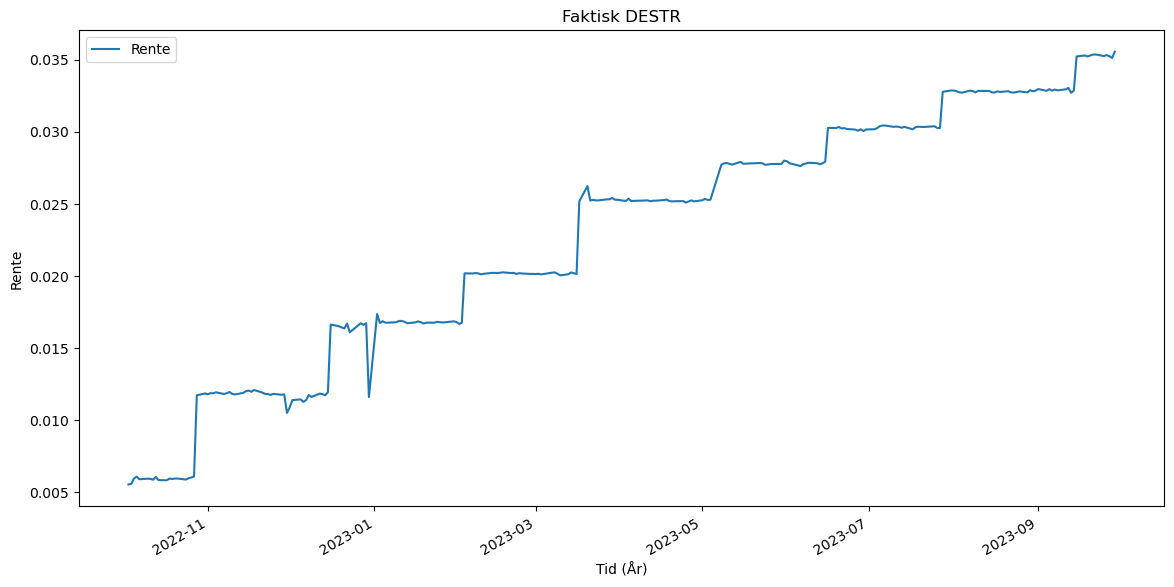

In [56]:
df.plot(figsize=(14,7))
plt.xlabel("Tid (År)")
plt.ylabel("Rente")
plt.title("Faktisk DESTR")
# plt.legend()
# plt.figure(figsize=(14, 7))
# plt.show()
fig = plt.gcf()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("DESTR.tex")

In [57]:
temp_array = df[["Rente"]].to_numpy()
print(type(temp_array))

def Vasicek_LS(r, dt):
    
    #Linear Regression
    r0 = r[:-1,]
    r1 = r[1:, 0]
    reg = LinearRegression().fit(r0, r1)
    
    #estimation a and b
    a_LS = (1 - reg.coef_) / dt
    b_LS = reg.intercept_ / dt / a_LS
    
    #estimation sigma
    epsilon = r[1:, 0] - r[:-1,0] * reg.coef_
    sigma_LS = np.std(epsilon) / dt**0.5
    return a_LS[0], b_LS[0], sigma_LS

LS_Estimate = Vasicek_LS(temp_array, 1) # dt = 250/250
a_est = np.round(LS_Estimate[0],4)
b_est = np.round(LS_Estimate[1],4)
sigma_est = np.round(LS_Estimate[2],4)

print('initial r:', str(df['Rente'][-1]))
print("a_est: " + str(a_est))
print("b_est: " + str(b_est))
print("sigma_est: " + str(sigma_est))

<class 'numpy.ndarray'>
initial r: 0.03555
a_est: 0.0078
b_est: 0.0378
sigma_est: 0.0008


In [58]:
N = 253  # time steps
dt = 1 # 250/250
X_1 = temp_array
# formulas for the OLS estimators kappa and theta
num = (
    N**2
    - 2 * N
    + 1
    + sum(X_1[1:]) * sum(1 / X_1[:-1])
    - sum(X_1[:-1]) * sum(1 / X_1[:-1])
    - (N - 1) * sum(X_1[1:] / X_1[:-1])
)
den = (N**2 - 2 * N + 1 - sum(X_1[:-1]) * sum(1 / X_1[:-1])) * dt
kappa_OLS = num / den
theta_OLS = ((N - 1) * sum(X_1[1:]) - sum(X_1[1:] / X_1[:-1]) * sum(X_1[:-1])) / num

# residuals of the regression
YY = (X_1[1:] - X_1[:-1]) / np.sqrt(X_1[:-1])  # response variable
XX1 = 1 / np.sqrt(X_1[:-1])  # regressor 1
XX2 = np.sqrt(X_1[:-1])  # regressor 2
sigma_OLS = np.std(YY - theta_OLS * kappa_OLS * dt * XX1 + dt * kappa_OLS * XX2, ddof=2) / np.sqrt(dt)
print("kappa OLS: ", kappa_OLS)
print("theta OLS: ", theta_OLS)
print("sigma OLS: ", sigma_OLS)

kappa OLS:  [-0.01963239]
theta OLS:  [0.01617628]
sigma OLS:  0.007903691635347493


In [59]:
def least_sq(c):
    return sum((YY - c[1] * c[0] * dt * XX1 + dt * c[0] * XX2) ** 2)


res = minimize(least_sq, x0=[1, 1], method="L-BFGS-B", bounds=[[1e-15, None], [1e-15, None]], tol=1e-8) 
sigma_OLS = np.std(YY - res.x[1] * res.x[0] * dt * XX1 + dt * res.x[0] * XX2, ddof=2) / np.sqrt(dt)

print("kappa OLS: ", res.x[0])
print("theta OLS: ", res.x[1])
print("sigma OLS: ", sigma_OLS)
kappa_OLS_temp = res.x[0]
theta_OLS_temp = res.x[1]
sigma_OLS_temp = sigma_OLS



kappa OLS:  0.0101721894505999
theta OLS:  0.0342210730945204
sigma OLS:  0.007558876770646216


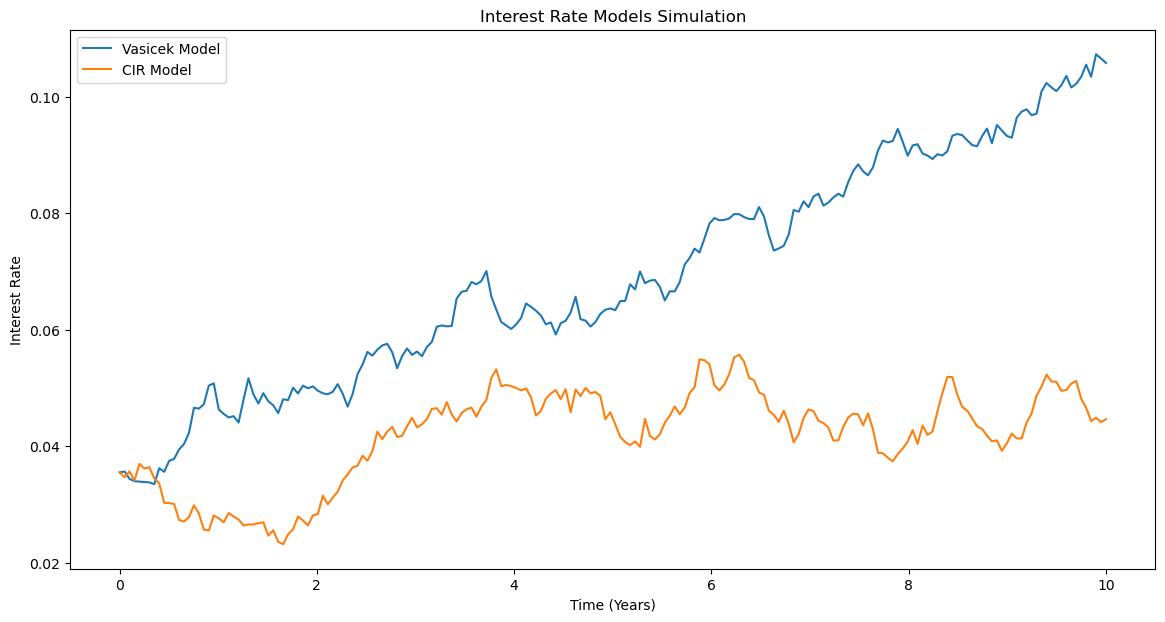

In [60]:
# Parameters - Vasicek Model
r0_vasicek = df['Rente'][-1] # Initial short rate
kappa_vasicek = kappa_OLS_temp # Speed of mean reversion
theta_vasicek = theta_OLS_temp # Long-term mean rate
sigma_vasicek = sigma_OLS_temp # Volatility
# kappa_vasicek = a_est # Speed of mean reversion
# theta_vasicek = b_est # Long-term mean rate
# sigma_vasicek = sigma_est # Volatility
# r0_vasicek = 0.05 # Initial short rate
# kappa_vasicek = 0.1 # Speed of mean reversion
# theta_vasicek = 0.05 # Long-term mean rate
# sigma_vasicek = 0.02 # Volatility
startdato = datetime(2023, 10, 1)  # Issue date
slutdato = datetime(2024, 4, 1)  # Maturity date (10 years later)
tempT = (slutdato - startdato).days / 252
T = tempT # Time horizon
T = 10 # Time horizon
dt = 0.05 # Time step
steps = int(T / dt)
t = np.linspace(0, T, steps)

# Vasicek Model Sim
def simulate_vasicek(r0, kappa, theta, sigma, T, dt):
    steps = int(T / dt)
    rates = np.zeros(steps)
    rates[0] = r0
    # np.random.seed(12)
    for i in range(1, steps):
        dr = kappa * (theta - rates[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[i] = rates[i-1] + dr
    return rates

# Parameters - CIR Model
# r0_cir = r0_vasicek
# kappa_cir = kappa_vasicek
# theta_cir = theta_vasicek
r0_cir = r0_vasicek
kappa_cir = kappa_OLS_temp
theta_cir = theta_OLS_temp
sigma_cir = sigma_vasicek/np.sqrt(r0_cir)
# sigma_cir = sigma_OLS_temp


# CIR Model Sim
def simulate_cir(r0, kappa, theta, sigma, T, dt):
    steps = int(T / dt)
    rates = np.zeros(steps)
    rates[0] = r0
    # np.random.seed(12)
    for i in range(1, steps):
        dr = kappa * (theta - rates[i-1]) * dt + sigma * np.sqrt(rates[i-1]) * np.sqrt(dt) * np.random.normal()
        rates[i] = max(rates[i-1] + dr, 0) # Ensure rates are non-negative
    return rates

# Simulating & plotting the models
vasicek_rates = simulate_vasicek(r0_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, T, dt)
cir_rates = simulate_cir(r0_cir, kappa_cir, theta_cir, sigma_cir, T, dt)

plt.figure(figsize=(14, 7))

plt.plot(t, vasicek_rates, label="Vasicek Model")
plt.plot(t, cir_rates, label="CIR Model")

plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.title("Interest Rate Models Simulation")
plt.legend()
plt.show()
# fig = plt.gcf()
# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save("test.tex")

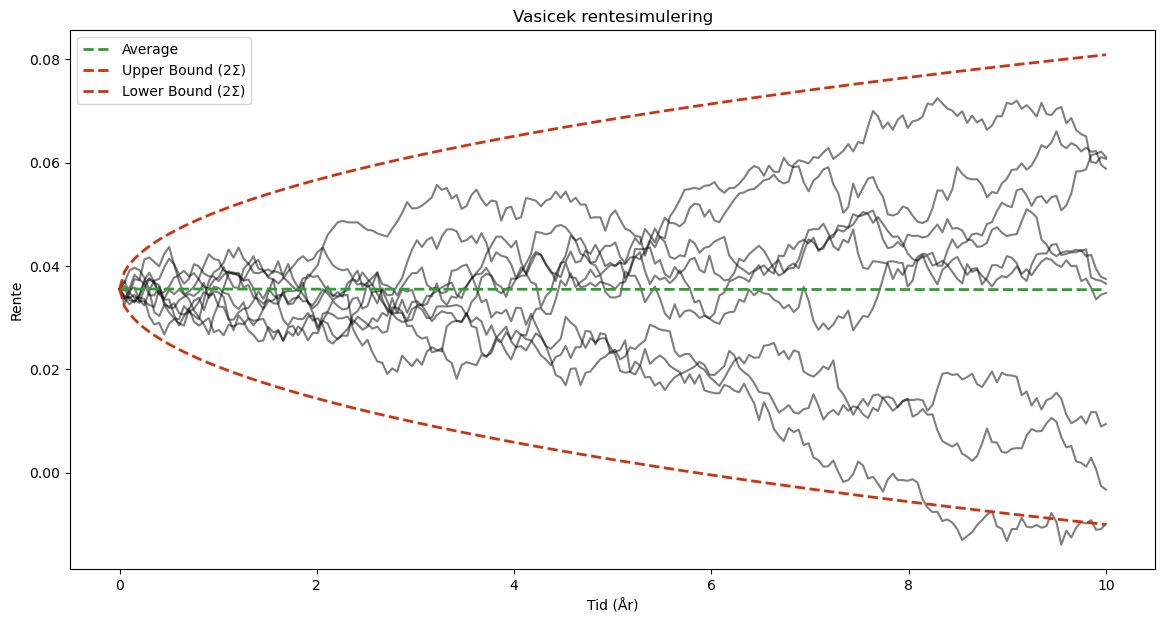

In [61]:
plt.figure(figsize=(14, 7))
df_vasicek = pd.DataFrame({'t': t})
np.random.seed(123)
for i in range(9):
    plt.plot(t, simulate_vasicek(r0_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, T, dt), color='black', alpha=0.5)
    if i < 8:
        df_vasicek['sti' + str(i)] = simulate_vasicek(r0_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, T, dt)

#expected value
expected_rates = [r0_vasicek * np.exp(-kappa_vasicek * t) + theta_vasicek * (1 - np.exp(-kappa_vasicek * t)) for t in t]

# standard deviation
std_dev = [(sigma_vasicek**2 / (2 * kappa_vasicek) * (1 - np.exp(-2 * kappa_vasicek * t)))**.5 for t in t]

# Calculate upper and lower bounds (±2 sigma)
upper_bound = [expected_rates[i] + 2 * std_dev[i] for i in range(len(t))]
lower_bound = [expected_rates[i] - 2 * std_dev[i] for i in range(len(t))]

plt.plot(t, expected_rates, color='#2ca02c',linestyle='--', label ='Average', linewidth=2)
plt.plot(t, upper_bound, color='#cc3311', linestyle='--', label='Upper Bound (2Σ)', linewidth=2)
plt.plot(t, lower_bound, color='#cc3311', linestyle='--', label='Lower Bound (2Σ)', linewidth=2)

plt.xlabel("Tid (År)")
plt.ylabel("Rente")
plt.title("Vasicek rentesimulering")
plt.legend()
# plt.show()
df_vasicek.to_csv('simVasicek2.csv', index=False)  

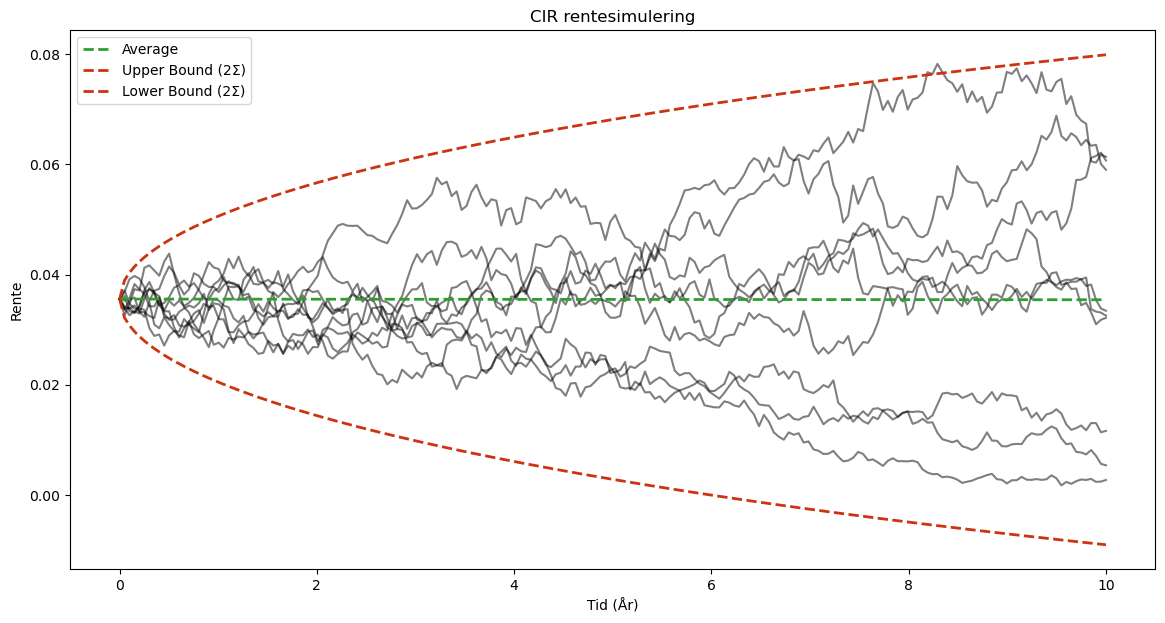

In [62]:
plt.figure(figsize=(14, 7))
# plt.subplot(1, 2, 1)
df_cir = pd.DataFrame({'t': t})
np.random.seed(123)
for i in range(9):
    plt.plot(t, simulate_cir(r0_cir, kappa_cir, theta_cir, sigma_cir, T, dt), color='black', alpha=0.5)
    if i < 8:
        df_cir['sti' + str(i)] = simulate_cir(r0_cir, kappa_cir, theta_cir, sigma_cir, T, dt)


#expected value
expected_rates = [r0_cir * np.exp(-kappa_cir * t) + theta_cir * (1 - np.exp(-kappa_cir * t)) for t in t]

# standard deviation
std_dev = [(r0_cir * sigma_cir**2 / (kappa_cir) * (np.exp(-kappa_cir * t) - np.exp(-2 * kappa_cir * t) + (theta_cir * sigma_cir**2 / (2 * kappa_cir)) * (1- np.exp(-kappa_cir * t)**2) ))**.5 for t in t]

# Calculate upper and lower bounds (±2 sigma)
upper_bound = [expected_rates[i] + 2 * std_dev[i] for i in range(len(t))]
lower_bound = [expected_rates[i] - 2 * std_dev[i] for i in range(len(t))]

plt.plot(t, expected_rates, color='#2ca02c',linestyle='--', label ='Average', linewidth=2)
plt.plot(t, upper_bound, color='#cc3311', linestyle='--', label='Upper Bound (2Σ)', linewidth=2)
plt.plot(t, lower_bound, color='#cc3311', linestyle='--', label='Lower Bound (2Σ)', linewidth=2)

plt.xlabel("Tid (År)")
plt.ylabel("Rente")
plt.title("CIR rentesimulering")        
plt.legend()

# plt.subplot(1,2,2)
# x_axis = np.linspace(expected_rates[-1] - 3*std_dev[-1], expected_rates[-1] + 3*std_dev[-1], 100)
# plt.plot(x_axis, norm.pdf(x_axis, expected_rates[-1], std_dev[-1]))

plt.show()
df_cir.to_csv('simCir2.csv', index=False) 

In [63]:
def zero_coupon(tau, r0, kappa, theta, sigma, model):
  if model == 'Vasicek':
    B = (1- np.exp(-kappa * tau)) / kappa
    A = np.exp((theta - sigma**2 / (2* kappa**2)) * (B - tau) - (sigma**2 / (4 * kappa)) * B**2)

  elif model == 'CIR':
    g = np.sqrt(kappa**2+2*sigma**2)
    B = (2*(np.exp(tau*g)-1))/(2*g+(kappa+g)*(np.exp(tau*g)-1))
    A = (2*g*np.exp((kappa+g)*tau/2)/(2*g+(kappa+g)*(np.exp(tau*g)-1)))**(2*kappa*theta/sigma**2)

  else:
    print('zero coupon: model must be Vasicek or CIR')
    return -1

  p = A * np.exp(-B * r0)
  # r = -(1.0/tau) * np.log(p)
  return p

In [64]:
print(r0_vasicek)
print(kappa_vasicek)
print(theta_vasicek)
print(sigma_vasicek)
print(sigma_cir)

0.03555
0.0101721894505999
0.0342210730945204
0.007558876770646216
0.04009012983382878


In [102]:
## med startdato i 2023

annu_ = 1
T_ = 30.0
Ts = np.r_[0.0:T_ + annu_:annu_]

zcbs = [zero_coupon(t, r0_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, 'Vasicek') for t in Ts]

zcrs = [-(1.0/t) * np.log(zero_coupon(t, r0_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, 'Vasicek')) for t in Ts[1:]]
zcrs[:0] = [r0_vasicek]

oneyearfwr = [1 / (Ts[t] - Ts[t-1]) * np.log( zcbs[t-1] / zcbs[t] ) for t in range(len(Ts))[1:]]
oneyearfwr[:0] = [r0_vasicek]

parswapr = [ (1/annu_) * (1 - zcbs[t] ) / sum(zcbs[1:t + 1]) for t in range(len(Ts))[1:]]
parswapr[:0] = [r0_vasicek]
# Ts # Løbeid
# zcbs # Nulkuponobligationspriser
# zcrs # nulkupon renter
# oneyearfwr # 1-årige forwardrenter
# parswapr # par-swap rente

struktur_df = pd.DataFrame(
    {'Løbetid': Ts,
     'Nulkuponrenter': zcrs,
     'Diskonteringsfaktor': zcbs,
     '1-årige Forwardrenter': oneyearfwr,
     'Swaprenter': parswapr
    })

struktur_df


,Løbetid,Nulkuponrenter,Diskonteringsfaktor,1-årige Forwardrenter,Swaprenter
0,0.0,0.035550,1.000000,0.035550,0.035550
1,1.0,0.035534,0.965090,0.035534,0.036173
2,2.0,0.035499,0.931464,0.035464,0.036137
3,3.0,0.035446,0.899120,0.035340,0.036084
4,4.0,0.035376,0.868053,0.035164,0.036014
5,5.0,0.035288,0.838251,0.034936,0.035928
6,6.0,0.035183,0.809696,0.034658,0.035827
7,7.0,0.035061,0.782369,0.034333,0.035712
8,8.0,0.034924,0.756245,0.033961,0.035583
9,9.0,0.034770,0.731298,0.033544,0.035441


In [79]:
## med startdato i 2024

annu_ = 1
T_ = 30.0
Ts = np.r_[0.0:T_ + annu_:annu_]

zcbs = [zero_coupon(t, theta_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, 'Vasicek') for t in Ts]

zcrs = [-(1.0/t) * np.log(zero_coupon(t, theta_vasicek, kappa_vasicek, theta_vasicek, sigma_vasicek, 'Vasicek')) for t in Ts[1:]]
zcrs[:0] = [theta_vasicek]

oneyearfwr = [1 / (Ts[t] - Ts[t-1]) * np.log( zcbs[t-1] / zcbs[t] ) for t in range(len(Ts))[1:]]
oneyearfwr[:0] = [theta_vasicek]

parswapr = [ (1/annu_) * (1 - zcbs[t] ) / sum(zcbs[1:t + 1]) for t in range(len(Ts))[1:]]
parswapr[:0] = [theta_vasicek]
# Ts # Løbeid
# zcbs # Nulkuponobligationspriser
# zcrs # nulkupon renter
# oneyearfwr # 1-årige forwardrenter
# parswapr # par-swap rente

struktur_df_2024 = pd.DataFrame(
    {'Løbetid': Ts,
     'Nulkuponrenter': zcrs,
     'Diskonteringsfaktor': zcbs,
     '1-årige Forwardrenter': oneyearfwr,
     'Swaprenter': parswapr
    })

struktur_df_2024

,Løbetid,Nulkuponrenter,Diskonteringsfaktor,1-årige Forwardrenter,Swaprenter
0,0.0,0.034221,1.000000,0.034221,0.034221
1,1.0,0.034212,0.966367,0.034212,0.034804
2,2.0,0.034184,0.933918,0.034155,0.034775
3,3.0,0.034137,0.902658,0.034045,0.034729
4,4.0,0.034073,0.872587,0.033881,0.034665
5,5.0,0.033992,0.843699,0.033666,0.034586
6,6.0,0.033894,0.815984,0.033402,0.034491
7,7.0,0.033779,0.789425,0.033089,0.034382
8,8.0,0.033647,0.764006,0.032730,0.034258
9,9.0,0.033501,0.739704,0.032325,0.034122


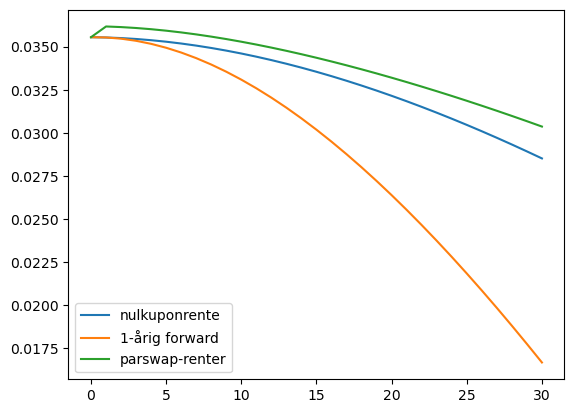

In [103]:
plt.plot(Ts, zcrs, label='nulkuponrente')
plt.plot(Ts, oneyearfwr, label='1-årig forward')
plt.plot(Ts, parswapr, label='parswap-renter')
plt.legend()
fig = plt.gcf()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save("rentestruktur.tex")
# plt.plot(Ts, zcbs)

In [99]:
import numpy as np

def monte_carlo_swaption_price(forward_swap_rate, strike_rate, time_to_expiration, swap_annuity, volatility, num_simulations, num_steps, theta, kappa, option_type='call'):
    """
    Calculate the price of a European swaption using Monte Carlo simulation.

    Parameters:
    forward_swap_rate (float): The forward rate of the swap.
    strike_rate (float): The strike rate of the swaption.
    time_to_expiration (float): The time to expiration of the swaption in years.
    swap_annuity (float): The annuity of the swap (present value of the fixed leg of the swap).
    volatility (float): The volatility of the forward swap rate (as a decimal).
    num_simulations (int): Number of Monte Carlo simulations.
    num_steps (int): Number of time steps in the simulation.
    option_type (str): 'call' for a payer swaption or 'put' for a receiver swaption.

    Returns:
    float: The price of the swaption.
    """

    dt = time_to_expiration / num_steps
    discount_factor = np.exp(-forward_swap_rate * time_to_expiration)
    
    # Generate Monte Carlo simulations
    simulated_swap_rates = np.zeros(num_simulations)
    np.random.seed(123)
    for i in range(num_simulations):
        rate = forward_swap_rate
        for _ in range(num_steps):
            # dr = kappa * (theta - simulated_swap_rates[i-1]) * dt + volatility * np.sqrt(dt) * np.random.normal()
            # simulated_swap_rates[i] = simulated_swap_rates[i-1] + dr
            
            # Generate a random rate movement based on normal distribution
            rate += kappa * (theta - rate) * dt + volatility * np.sqrt(dt) * np.random.normal() # vasicek
            # rate += kappa * (theta - rate) * dt + volatility * np.sqrt(rate) * np.sqrt(dt) * np.random.normal() # CIR 
        
        # Calculate the payoff for this simulation
        if option_type == 'call':  # Payer swaption
            simulated_swap_rates[i] = max(rate - strike_rate, 0) * swap_annuity
        elif option_type == 'put':  # Receiver swaption
            simulated_swap_rates[i] = max(strike_rate - rate, 0) * swap_annuity

    # Calculate the present value of the average payoff
    swaption_price = discount_factor * np.mean(simulated_swap_rates)
    
    return swaption_price

# Example parameters
forward_swap_rate = 0.035534 # Forward swap rate
strike_rate = 0.036173  # Strike rate = parswaprate
startdato = datetime(2023, 10, 1)  # Issue date
slutdato = datetime(2024, 4, 1)  # Maturity date 
tempT = (slutdato - startdato).days / 252
time_to_expiration = tempT  
swap_annuity = 1000  # Present value of the fixed leg of the swap
volatility = sigma_vasicek#/np.sqrt(r0_cir) #fjern kommentar hvis CIR
kappa = kappa_vasicek
theta = theta_vasicek
num_simulations = 10000  # Number of Monte Carlo simulations
num_steps = 100  # Number of time steps in the simulation

# Calculate swaption price for a payer swaption (call option)
payer_swaption_price = monte_carlo_swaption_price(forward_swap_rate, strike_rate, time_to_expiration, swap_annuity, volatility, num_simulations, num_steps, theta, kappa, option_type='call')
print(f"The payer swaption price is: {payer_swaption_price:.2f}")

# Calculate swaption price for a receiver swaption (put option)
receiver_swaption_price = monte_carlo_swaption_price(forward_swap_rate, strike_rate, time_to_expiration, swap_annuity, volatility, num_simulations, num_steps, theta, kappa, option_type='put')
print(f"The receiver swaption price is: {receiver_swaption_price:.2f}")


The payer swaption price is: 2.26
The receiver swaption price is: 2.85
